<a href="https://colab.research.google.com/github/verma7/AdventOfCode2021/blob/master/RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# RL

In [3]:
!pip install tf-agents[reverb]
!pip install tf-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 70.6 MB/s eta 0:00:00
   ━━━

In [4]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [5]:
!pip install galois

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 30.8 MB/s eta 0:00:00


In [180]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
import random
import galois
import pandas as pd

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

from tf_agents.policies import random_py_policy
from tf_agents.policies import random_tf_policy
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.drivers import dynamic_step_driver

from tf_agents import specs
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network
from tf_agents.replay_buffers import py_uniform_replay_buffer
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [7]:
def get_num_ones(w):
    "Returns a vector containing the number of ones in the bit representation in each element of the GF(2^w) field."
    N = 2 ** w
    GF = galois.GF(N)
    num_ones = np.zeros(N)
    for i in range(N):
        for j in range(w):
            v = np.multiply(GF(i), GF(2 ** j))
            num_ones[i] += bin(v).count("1")
    return num_ones

def count_ones(GC, n, m, ones):
    sum_ones = 0
    for i in range(n):
        for j in range(m):
            sum_ones += ones[int(GC[i][j])]
    return sum_ones

In [256]:
class CauchyEnv(py_environment.PyEnvironment):

  def __init__(self, W, m, vec, num_ones_list):
    self._W = W
    self._N = 2 ** self._W
    self._m = m
    self._GF = galois.GF(self._N)
    self._ONES = get_num_ones(self._W)
    self._num_ones_list = num_ones_list

    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int64, minimum=0, maximum=self._N * self._N - 1, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(self._N, ), dtype=np.int32, minimum=0, maximum=2, name='observation')
    self._initialize(vec)

  def _good_cauchy_matrix(self):
    GC = np.zeros((self._m, self._m))
    x = 0
    y = 0
    for i in range(self._N):
       if self._state[i] == 0:
          y = 0
          for j in range(self._N):
              if self._state[j] == 1:
                sum = self._GF(i) + self._GF(j)
                if sum == 0:
                    continue
                GC[x][y] = sum ** -1
                y += 1
          x += 1
    return GC

  def _initialize(self, vec):
    self._best_num_ones = 1e8
    self._vec = vec
    self._state = [0] * self._N
    for i in self._vec[:self._m]:
        self._state[i] = 0
    for i in self._vec[self._m:2*self._m]:
        self._state[i] = 1
    for i in self._vec[2*self._m:]:
        self._state[i] = 2
    self._GC = self._good_cauchy_matrix()
    self._num_ones = count_ones(self._GC, self._m, self._m, self._ONES)
    self._time_steps_without_improvement = 0

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self._initialize(self._vec)
    return ts.restart(np.array(self._state, dtype=np.int32))

  def _swap(self, action):
    x = action // self._N
    y = action % self._N
    if self._state[x] == self._state[y]:
      return

    tmp = self._state[x]
    self._state[x] = self._state[y]
    self._state[y] = tmp

  def _step(self, action):
    if action >= 0 and action < self._N * self._N:
      self._swap(action)
    else:
      raise ValueError(f'`action` should be between [0, {self._N * self._N}), but is {action}')

    self._GC = self._good_cauchy_matrix()
    new_num_ones = count_ones(self._GC, self._m, self._m, self._ONES)
    reward = new_num_ones - self._num_ones
    self._num_ones = new_num_ones
    self._num_ones_list.append(new_num_ones)
    if new_num_ones < self._best_num_ones:
      self._best_num_ones = new_num_ones
      # print(f'Best num ones = {new_num_ones}')
      self._time_steps_without_improvement = 0
    else:
      self._time_steps_without_improvement += 1

    if self._time_steps_without_improvement == 100:
      return ts.termination(np.array(self._state, dtype=np.int32), reward)
    else:
      return ts.transition(np.array(self._state, dtype=np.int32), reward=reward, discount=1.0)

In [257]:
w = 4
m = 4
N = 2 ** w
vec = [ i for i in range(N)]
random.shuffle(vec)

R = np.zeros((N, N))
num_ones = []
for i in range(N * N):
  environment = CauchyEnv(w, m, vec, num_ones)
  time_step = environment.reset()
  time_step = environment.step(i)
  R[i//N][i%N] = time_step.reward

print(num_ones)
for i in range(N):
  print(' '.join([f"{R[i][j]:3.0f}" for j in range(N)]))

[127.0, 127.0, 127.0, 136.0, 106.0, 116.0, 124.0, 119.0, 125.0, 119.0, 127.0, 126.0, 117.0, 122.0, 126.0, 128.0, 127.0, 127.0, 127.0, 142.0, 132.0, 130.0, 136.0, 131.0, 135.0, 131.0, 127.0, 138.0, 129.0, 134.0, 138.0, 140.0, 127.0, 127.0, 127.0, 133.0, 131.0, 127.0, 128.0, 123.0, 136.0, 123.0, 127.0, 130.0, 121.0, 126.0, 130.0, 132.0, 136.0, 142.0, 133.0, 127.0, 127.0, 127.0, 142.0, 139.0, 127.0, 138.0, 146.0, 129.0, 141.0, 135.0, 136.0, 133.0, 106.0, 132.0, 131.0, 127.0, 127.0, 127.0, 129.0, 126.0, 127.0, 125.0, 134.0, 116.0, 128.0, 122.0, 123.0, 120.0, 116.0, 130.0, 127.0, 127.0, 127.0, 127.0, 135.0, 132.0, 127.0, 131.0, 134.0, 122.0, 134.0, 128.0, 129.0, 126.0, 124.0, 136.0, 128.0, 142.0, 129.0, 135.0, 127.0, 127.0, 139.0, 127.0, 137.0, 127.0, 127.0, 127.0, 127.0, 127.0, 119.0, 131.0, 123.0, 139.0, 126.0, 132.0, 127.0, 127.0, 136.0, 127.0, 132.0, 127.0, 127.0, 127.0, 127.0, 127.0, 125.0, 135.0, 136.0, 127.0, 127.0, 127.0, 139.0, 136.0, 127.0, 135.0, 139.0, 126.0, 138.0, 132.0, 133.0

In [215]:
vec = [ i for i in range(2**3)]
random.shuffle(vec)

num_ones = []
env = wrappers.TimeLimit(CauchyEnv(3, 3, vec, num_ones), 101)
tf_env = tf_py_environment.TFPyEnvironment(env)
print(isinstance(tf_env, tf_environment.TFEnvironment))
print("TimeStep Specs:", tf_env.time_step_spec())
print("Action Specs:", tf_env.action_spec())

True
TimeStep Specs: TimeStep(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(8,), dtype=tf.int32, name='observation', minimum=array(0, dtype=int32), maximum=array(2, dtype=int32))})
Action Specs: BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(63))


In [258]:
vec = [ i for i in range(2 ** 4)]
random.shuffle(vec)
num_ones = []
env = wrappers.TimeLimit(CauchyEnv(4, 5, vec, num_ones), 101)
tf_env = tf_py_environment.TFPyEnvironment(env)

tf_policy = random_tf_policy.RandomTFPolicy(action_spec=tf_env.action_spec(),
                                            time_step_spec=tf_env.time_step_spec())


num_episodes = tf_metrics.NumberOfEpisodes()
env_steps = tf_metrics.EnvironmentSteps()
max_return = tf_metrics.MaxReturnMetric()
replay_buffer = []
observers = [num_episodes, env_steps, max_return, replay_buffer.append]
driver = dynamic_episode_driver.DynamicEpisodeDriver(
    tf_env, tf_policy, observers, num_episodes=10)

# Initial driver.run will reset the environment and initialize the policy.
final_time_step, policy_state = driver.run()

print('final_time_step', final_time_step)
print('Number of Steps: ', env_steps.result().numpy())
print('Number of Episodes: ', num_episodes.result().numpy())
print('Max Return: ', max_return.result().numpy())
print('Min num_ones: ', np.min(num_ones))

final_time_step TimeStep(
{'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 16), dtype=int32, numpy=array([[1, 0, 1, 2, 2, 2, 2, 2, 1, 0, 0, 2, 0, 1, 0, 1]], dtype=int32)>})
Number of Steps:  1010
Number of Episodes:  10
Max Return:  4.0
Min num_ones:  180.0


In [259]:
learning_rate = 1e-5

W = 3
vec = [ i for i in range(2 ** W)]
random.shuffle(vec)
num_ones = []
environment = CauchyEnv(W, 3, vec, num_ones)
tf_env = tf_py_environment.TFPyEnvironment(environment)

eval_num_ones = []
eval_environment = CauchyEnv(W, 5, vec, eval_num_ones)
tf_eval_env = tf_py_environment.TFPyEnvironment(eval_environment)

fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(tf_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate))

replay_buffer_capacity = 10000

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_capacity)
replay_buffer.clear()

# Add an observer that adds to the replay buffer:
replay_observer = [replay_buffer.add_batch]

collect_steps_per_iteration = 1000
collect_op = dynamic_step_driver.DynamicStepDriver(
  tf_env,
  agent.collect_policy,
  observers=replay_observer,
  num_steps=collect_steps_per_iteration).run()

print(num_ones)
print(f"Best num_ones = {np.min(num_ones)}")

[48.0, 48.0, 48.0, 46.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 48.0, 46.0, 47.0, 47.0, 44.0, 44.0, 51.0, 44.0, 51.0, 44.0, 51.0, 44.0, 51.0, 44.0, 51.0, 44.0, 51.0, 44.0, 51.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 53.0, 44.0, 53.0, 44.0, 53.0, 44.0, 53.0, 53.0, 49.0, 49.0, 46.0, 46.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 41.0, 49.0, 41.0, 49.0, 41.0, 49.0, 41.0, 49.0, 41.0, 49.0, 48.0, 45.0, 48.0, 45.0, 48.0, 45.0, 48.0, 45.0, 48.0, 45.0, 48.0, 45.0, 48.0, 45.0, 48.0, 45.0, 48.

In [279]:
def compute_min_ones(environment, policy, num_ones, num_episodes=10):
  total_num_ones = 0
  actions = []
  for _ in range(num_episodes):
    time_step = environment.reset()
    num_ones.clear()
    actions.clear()
    rewards_list = []
    rewards = 0
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      rewards_list = np.concatenate((rewards_list, time_step.reward.numpy()))
      rewards += time_step.reward
      actions.append(action_step.action.numpy())
    print(actions)
    print(num_ones)
    print(rewards.numpy())
    print(rewards_list)
    total_num_ones += np.min(num_ones)
  return total_num_ones / num_episodes

In [280]:
log_interval = 100
eval_interval = 100

num_train_steps = 100
df = pd.DataFrame()

dataset = replay_buffer.as_dataset(
    sample_batch_size=10,
    num_steps=2)
iterator = iter(dataset)

for step in range(num_train_steps):
  trajectories, _ = next(iterator)
  train_loss = agent.train(experience=trajectories).loss

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))
  if step % eval_interval == 0:
    min_ones = compute_min_ones(tf_eval_env, agent.collect_policy, eval_num_ones)
    print('step = {0}: min_ones = {1}'.format(step, min_ones))
  df = pd.concat([df, pd.DataFrame({'step': [step], 'min_ones': [min_ones], 'loss': [train_loss.numpy()]})])
print(df)

step = 0: loss = 2.3630640506744385
[array([12]), array([12]), array([12]), array([12]), array([59]), array([12]), array([12]), array([12]), array([12]), array([12]), array([12]), array([12]), array([12]), array([12]), array([12]), array([11]), array([22]), array([22]), array([22]), array([22]), array([22]), array([22]), array([22]), array([13]), array([22]), array([27]), array([22]), array([22]), array([22]), array([22]), array([22]), array([22]), array([43]), array([12]), array([12]), array([12]), array([12]), array([12]), array([12]), array([49]), array([12]), array([12]), array([12]), array([12]), array([12]), array([12]), array([12]), array([0]), array([12]), array([12]), array([12]), array([12]), array([62]), array([21]), array([21]), array([21]), array([21]), array([21]), array([21]), array([36]), array([21]), array([39]), array([21]), array([21]), array([21]), array([21]), array([21]), array([21]), array([41]), array([21]), array([21]), array([21]), array([21]), array([21]), ar

In [234]:
print(agent.policy)

<Axes: xlabel='step'>

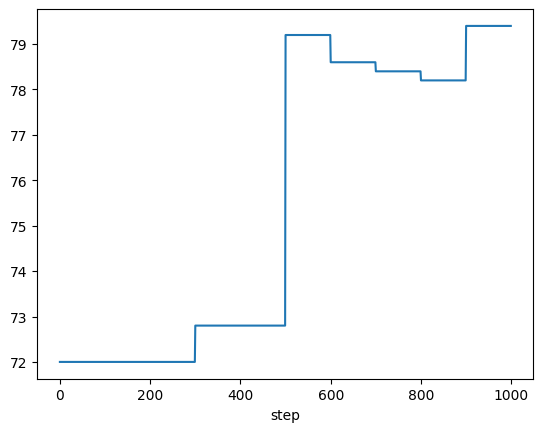

In [252]:
df.set_index('step', inplace=True)
df['min_ones'].plot()